# Adding the required imports

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline

import xgboost

import joblib


# Load the dataset

In [114]:
df = pd.read_csv("../data/2022_Q1_OR_Utilization.csv")
df.head()

,index,Encounter ID,Date,OR Suite,Service,CPT Code,CPT Description,Booked Time (min),OR Schedule,Wheels In,Start Time,End Time,Wheels Out
0,0,10001,01/03/22,1,Podiatry,28110,"Partial ostectomy, fifth metatarsal head",90,01/03/22 07:00 AM,01/03/22 07:05 AM,01/03/22 07:32 AM,01/03/22 09:05 AM,01/03/22 09:17 AM
1,1,10002,01/03/22,1,Podiatry,28055,"Neurectomy, intrinsic musculature of foot",60,01/03/22 08:45 AM,01/03/22 09:48 AM,01/03/22 10:13 AM,01/03/22 11:01 AM,01/03/22 11:12 AM
2,2,10003,01/03/22,1,Podiatry,28297,Lapidus bunionectomy,150,01/03/22 10:00 AM,01/03/22 11:50 AM,01/03/22 12:20 PM,01/03/22 12:42 PM,01/03/22 12:58 PM
3,3,10004,01/03/22,1,Podiatry,28296,Bunionectomy with distal osteotomy,120,01/03/22 12:45 PM,01/03/22 01:29 PM,01/03/22 01:53 PM,01/03/22 02:50 PM,01/03/22 03:02 PM
4,4,10005,01/03/22,2,Orthopedics,27445,"Arthroplasty, knee, hinge prothesis",120,01/03/22 07:00 AM,01/03/22 07:15 AM,01/03/22 07:50 AM,01/03/22 09:38 AM,01/03/22 09:51 AM


In [115]:
# display the columns

In [116]:
df.columns

Index(['index', 'Encounter ID', 'Date', 'OR Suite', 'Service', 'CPT Code',
       'CPT Description', 'Booked Time (min)', 'OR Schedule', 'Wheels In',
       'Start Time', 'End Time', 'Wheels Out'],
      dtype='object')

# Basic cleaning and parsing

# Convert data/time to datetime

In [117]:
for col in ["Date", "Wheels In", "Wheels Out"]:
    df[col] = pd.to_datetime(df[col])

/var/folders/gl/rtk4gdps67v0p982cpbqjhs80000gn/T/ipykernel_5666/935226549.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/var/folders/gl/rtk4gdps67v0p982cpbqjhs80000gn/T/ipykernel_5666/935226549.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])
/var/folders/gl/rtk4gdps67v0p982cpbqjhs80000gn/T/ipykernel_5666/935226549.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col])


# Target variable actual case duratuon in minutes 

In [118]:
df["actual_duration_min"] = (df["Wheels Out"] - df["Wheels In"]).dt.total_seconds() / 60

# Compute overrun minutes based on booked time

In [119]:
df["overrun_min"] = (df["actual_duration_min"] - df["Booked Time (min)"]).clip(lower=0)

# Compute day of week and case hours

In [120]:
df["day_of_week"] = df["Date"].dt.dayofweek 
df["case_hour"] = df["Wheels In"].dt.hour

In [121]:
df[["Booked Time (min)", "actual_duration_min", "overrun_min"]].describe()

,Booked Time (min),actual_duration_min,overrun_min
count,2172.000000,2172.000000,2172.000000
mean,77.189227,79.697053,7.123849
std,30.430015,31.822390,8.729881
min,30.000000,19.000000,0.000000
25%,60.000000,62.000000,0.000000
50%,60.000000,73.000000,3.000000
75%,90.000000,96.000000,13.000000
max,180.000000,173.000000,42.000000


# EDA distributions

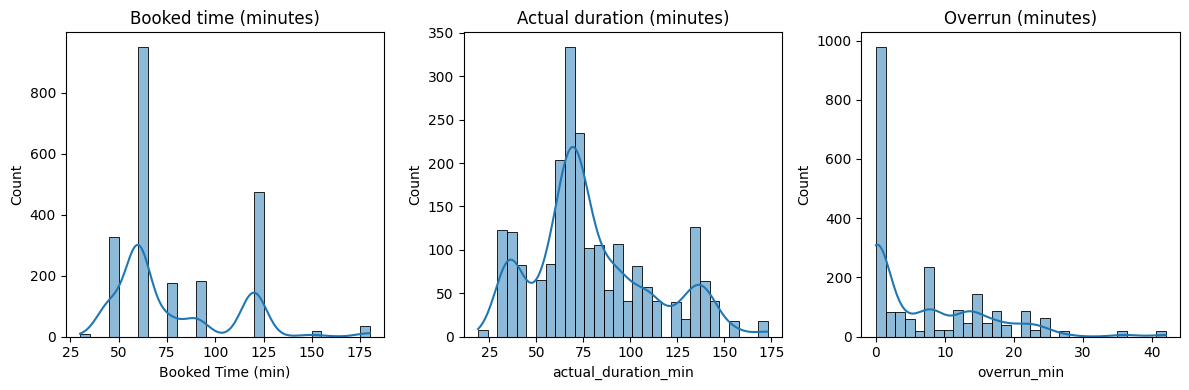

In [122]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(df["Booked Time (min)"], bins=30, kde=True)
plt.title("Booked time (minutes)")

plt.subplot(1, 3, 2)
sns.histplot(df["actual_duration_min"], bins=30, kde=True)
plt.title("Actual duration (minutes)")

plt.subplot(1, 3, 3)
sns.histplot(df["overrun_min"], bins=30, kde=True)
plt.title("Overrun (minutes)")

plt.tight_layout()
plt.show()

# Drop rows with missing key feilds

In [123]:

df_model = df.dropna(subset=["actual_duration_min", "Booked Time (min)", "Service", "CPT Code"]).copy()

num_features = ["Booked Time (min)", "day_of_week", "case_hour"]
cat_features = ["Service", "CPT Code"]

X = df_model[num_features + cat_features]
# Target variable
y = df_model["actual_duration_min"]

print("Rows used for modeling:", len(df_model))

# Splitting the training and testing dataset in 80 and 20 ratio
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42
)

# Data preprocessing
# The numerical features are passed thriough
# but the categorical featueres are ignored
preprocess = ColumnTransformer(
transformers=[
("num", "passthrough", num_features),
("cat", OneHotEncoder(handle_unknown="ignore"), cat_features),
]
)

Rows used for modeling: 2172


# Random Forest Regressor

In [124]:
# Create the random forest regressor model using the basic configuration
rf = RandomForestRegressor(
n_estimators=400,
random_state=42,
n_jobs=-1,
)

# Create the pipeline that preprocess the data and fits the model
rf_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", rf)])

print("Training RandomForestRegressor...")
# Training the model
rf_pipe.fit(X_train, y_train)

# Testing the model
rf_pred = rf_pipe.predict(X_test)
# Calculating the mae and r2 score
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print(f"Random Forest MAE: {rf_mae:.2f} minutes")
print(f"Random Forest R^2: {rf_r2:.3f}")

Training RandomForestRegressor...
Random Forest MAE: 0.68 minutes
Random Forest R^2: 0.991


# XGBoost

In [125]:
# Create the XGBoost regression model with a basic configuration
xgb_model = xgboost.XGBRegressor(
objective="reg:squarederror",
n_estimators=400,
max_depth=4,
learning_rate=0.05,
subsample=0.8,
colsample_bytree=0.8,
random_state=42,
n_jobs=-1,
)

# Build a pipeline that preprocesses the data and then fits the XGBoost model
xgb_pipe = Pipeline(steps=[("preprocess", preprocess), ("model", xgb_model)])

print("Training XGBRegressor...")
# Training the data
xgb_pipe.fit(X_train, y_train)

# Testing the data
xgb_pred = xgb_pipe.predict(X_test)

# MAE is calculated here
xgb_mae = mean_absolute_error(y_test, xgb_pred)

# R2 square is calculated here
xgb_r2 = r2_score(y_test, xgb_pred)

print(f"XGBoost MAE: {xgb_mae:.2f} minutes")
print(f"XGBoost R^2: {xgb_r2:.3f}")

Training XGBRegressor...
XGBoost MAE: 1.51 minutes
XGBoost R^2: 0.990


# Best model

In [126]:
if xgb_mae <= rf_mae:
    best_name = "XGBoost"
    best_pred = xgb_pred
    best_pipe = xgb_pipe
else:
    best_name = "RandomForest"
    best_pred = rf_pred
    best_pipe = rf_pipe

print(f"Best model based on MAE: {best_name}")

Best model based on MAE: RandomForest


# Save the best model

In [127]:
# save the chosel model to models folder
final_model_path = "../models/OptiOR.joblib"
# serializing the entire pipeline (preprocessing + model)
joblib.dump(
{
"pipeline": best_pipe,
"num_features": num_features,
"cat_features": cat_features,
},
final_model_path,
)
print("Saved best model (", best_name, ") to", final_model_path)

Saved best model ( RandomForest ) to ../models/OptiOR.joblib
